# Aims and goals
1. To create ML-model, which can predict the result of "Blood Bowl 3" Official Ladder match. Predictors should be simple and available in game at the moment of a match start.
2. To achieve better results, than random predicting.
3. To ruin goblins-bookmakers.

# Selecting predictors, data preparing
I choose following predictors:
- team race (in-game faction);
- opponent's team race;
- team TV (Team Value, correlates with team strength);
- opponent's team TV;
- team rating (Skill Rating, correlates with coach skill);
- opponent's team rating.
 
Target: result (W - win, D - draw, L - loss). 

Target metric: accuracy (share of correctly predicted results). More correctly predictiond - better.

Data colleted using Cyanide API, for training the model I gathered information about Official Ladder Seasons 1-5 results (all platforms), for testing I'll use results of partially finished 6th Season. Sadly, there are no public SR dynamics data, so this metric is recreated by myself using supposed SR formula (Elo rating with division-depended winstreak bonus).

Each played match gave us 2 lines in dataset (from each team POV).

# Loading libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import optuna
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
sns.set_theme(
    style='whitegrid',
    font_scale=2,
    palette='dark',
    rc={'figure.figsize': (9, 6)}
)

In [11]:
df1 = pd.read_csv("https://drive.google.com/uc?id=1xTXrmVQgyPIomVoaymtiCLzRHL-bVN95")
df2 = pd.read_csv("https://drive.google.com/uc?id=1mP2uLHxt0f0z1vzaHSZnZSH7n_L8QzX0")
df3 = pd.read_csv("https://drive.google.com/uc?id=1wvgRlDCYk08FSx4JHMpFoM7XWQPOYajT")
df4 = pd.read_csv("https://drive.google.com/uc?id=1CP9RjDihuCr9uT2y1uMKZUt6MS0GrQYC")
df5 = pd.read_csv("https://drive.google.com/uc?id=1EvOyJn9yNqHJjggZQ-I6smeHsRL6fN2w")
df6 = pd.read_csv("https://drive.google.com/uc?id=1y3_inp1CGhhqsnONtH8nzShbemeU7PZm")
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
df.info() # That's our training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719248 entries, 0 to 1719247
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   race        object 
 2   opp_race    object 
 3   value       int64  
 4   opp_value   int64  
 5   rating      float64
 6   opp_rating  float64
 7   if_concede  int64  
 8   if_leaver   int64  
 9   result      object 
dtypes: float64(2), int64(4), object(4)
memory usage: 131.2+ MB


In [12]:
df.sample(6)

,id,race,opp_race,value,opp_value,rating,opp_rating,if_concede,if_leaver,result
1384911,714a899d-280d-11ef-9178-bc24112ec32e,orc,orc,995,1000,1000.0,1000.0,0,0,W
127674,adc16d42-2c6e-11ee-af36-020000a4d571,human,elvenUnion,1570,1485,1162.0,1279.0,0,0,D
1463737,2bb67ab6-2481-11ee-b762-020000d1a054,human,chaosChosen,970,1000,1000.0,1000.0,0,0,D
1497038,ee22326c-97d0-11ee-b910-02000090a64f,chaosChosen,orc,940,1185,1000.0,1421.0,0,0,W
75039,f2f15178-3758-11ee-af36-020000a4d571,blackOrc,dwarf,1470,1420,1169.0,1217.0,0,0,W
1434158,3d05f7a5-3cfc-11ee-b762-020000d1a054,lizardman,chaosChosen,1185,1260,1141.0,1000.0,0,0,W


In [13]:
# Test dataset with partial Season 6 results. Remove Goblins and Halflings
# (introduced at Season 6, non-present at training dataset)
test_df = pd.read_csv(r"https://drive.google.com/uc?id=1nxWXQy4wSgEDvGf7Gn-zctFi5oFfkVT8")
test_df = test_df[
    ~test_df['race'].isin(['goblin', 'halfling']) & 
    ~test_df['opp_race'].isin(['goblin', 'halfling'])
]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223428 entries, 0 to 272347
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          223428 non-null  object 
 1   race        223428 non-null  object 
 2   opp_race    223428 non-null  object 
 3   value       223428 non-null  int64  
 4   opp_value   223428 non-null  int64  
 5   rating      223428 non-null  float64
 6   opp_rating  223428 non-null  float64
 7   if_concede  223428 non-null  int64  
 8   if_leaver   223428 non-null  int64  
 9   result      223428 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 18.8+ MB



percent of wins: 40.6%
percent of draws: 18.9%
percent of losses: 40.6%



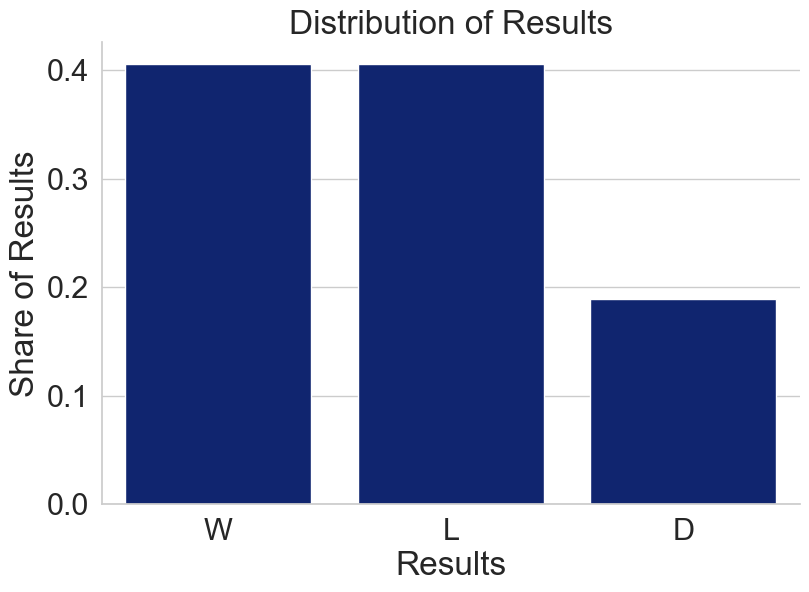

In [14]:
# Let's look at results distribution
test_class_counts = test_df['result'].value_counts(normalize=True)
W_weight = test_class_counts.W
D_weight = test_class_counts.D
L_weight = test_class_counts.L
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")
sns.barplot(x=test_class_counts.index, y=test_class_counts.values)
plt.title('Distribution of Results')
plt.xlabel('Results')
plt.ylabel('Share of Results')
sns.despine()

In [15]:
# Only about 1/6th of all games end in a draw. Keeping this in mind, add random results 
# (for comparing with our future predictions)
for row in test_df.itertuples():
    if row.Index % 2 == 0:
        test_df.loc[row.Index, 'random_result'] = np.random.choice(
            ['W', 'D', 'L'],
            p=[W_weight, D_weight, L_weight])
    else:
        if test_df.loc[row.Index - 1, 'random_result'] == 'W':
            test_df.loc[row.Index, 'random_result'] = 'L'
        elif test_df.loc[row.Index - 1, 'random_result'] == 'L':
            test_df.loc[row.Index, 'random_result'] = 'W'
        else:
            test_df.loc[row.Index, 'random_result'] = 'D'

test_df.head(6)

,id,race,opp_race,value,opp_value,rating,opp_rating,if_concede,if_leaver,result,random_result
0,4c847c6a-a673-11ef-aaf1-bc24112ec32e,woodElf,skaven,980,985,1000.0,1000.0,1,0,W,L
1,4c847c6a-a673-11ef-aaf1-bc24112ec32e,skaven,woodElf,985,980,1000.0,1000.0,1,1,L,W
2,13b8cc3e-a673-11ef-aaf1-bc24112ec32e,shamblingUndead,orc,1060,880,1588.0,1632.0,1,0,W,W
3,13b8cc3e-a673-11ef-aaf1-bc24112ec32e,orc,shamblingUndead,880,1060,1632.0,1588.0,1,1,L,L
4,ed363543-a672-11ef-aaf1-bc24112ec32e,oldWorldAlliance,orc,980,1000,1000.0,1000.0,1,1,L,W
5,ed363543-a672-11ef-aaf1-bc24112ec32e,orc,oldWorldAlliance,1000,980,1000.0,1000.0,1,0,W,L


In [16]:
random_accuracy = accuracy_score(test_df.result, test_df.random_result)
print(f'Accuracy with random (with actual draw share) predicting results: {random_accuracy:.1%}')

Accuracy with random (with actual draw share) predicting results: 36.4%


# Choosing model
## Model 1.1 - without class weights

In [17]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [21]:
random_state = 1
X_train_1_1, X_val_1_1, y_train_1_1, y_val_1_1 = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=random_state)

train_pool_1_1 = Pool(X_train_1_1, y_train_1_1, cat_features=CAT_FEATURES)
eval_pool_1_1 = Pool(X_val_1_1, y_val_1_1, cat_features=CAT_FEATURES)

In [27]:
model_1_1 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_1.fit(train_pool_1_1, eval_set=eval_pool_1_1, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.4659837	test: 0.4659648	best: 0.4659648 (0)	total: 1.18s	remaining: 1h 38m 34s
100:	learn: 0.5019732	test: 0.5015792	best: 0.5015792 (100)	total: 1m 31s	remaining: 1h 14m 13s
200:	learn: 0.5035401	test: 0.5027076	best: 0.5027454 (197)	total: 3m 2s	remaining: 1h 12m 28s
300:	learn: 0.5042555	test: 0.5032979	best: 0.5033183 (285)	total: 4m 31s	remaining: 1h 10m 44s
400:	learn: 0.5049200	test: 0.5036469	best: 0.5037604 (391)	total: 5m 58s	remaining: 1h 8m 34s
500:	learn: 0.5054202	test: 0.5040657	best: 0.5040803 (478)	total: 7m 25s	remaining: 1h 6m 38s
600:	learn: 0.5059968	test: 0.5042809	best: 0.5043275 (574)	total: 8m 53s	remaining: 1h 5m 6s
700:	learn: 0.5063909	test: 0.5043217	best: 0.5044176 (664)	total: 10m 25s	remaining: 1h 3m 58s
800:	learn: 0.5067573	test: 0.5042809	best: 0.5044671 (731)	total: 12m	remaining: 1h 2m 54s
900:	learn: 0.5070867	test: 0.5041006	best: 0.5044671 (731)	total: 13m 31s	remaining: 1h 1m 32s
1000:	learn: 0.5074080	test: 0.5042315	best: 0.5044671

In [28]:
# Save model
model_1_1.save_model('model_1_1.cbm')

In [19]:
# If need, load model
model_1_1 = CatBoostClassifier()
model_1_1.load_model('model_1_1.cbm')

In [23]:
y_pred_1_1 = model_1_1.predict(X_val_1_1)
accuracy_1_1 = accuracy_score(y_val_1_1, y_pred_1_1)
print(f'Accuracy: {accuracy_1_1:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_1, y_pred_1_1))

Accuracy: 50.6%
Classification Report:
              precision    recall  f1-score   support

           D       0.80      0.00      0.00     60156
           L       0.51      0.61      0.55    141615
           W       0.51      0.62      0.56    142079

    accuracy                           0.51    343850
   macro avg       0.60      0.41      0.37    343850
weighted avg       0.56      0.51      0.46    343850




percent of wins: 50.3%
percent of draws: 0.0%
percent of losses: 49.7%



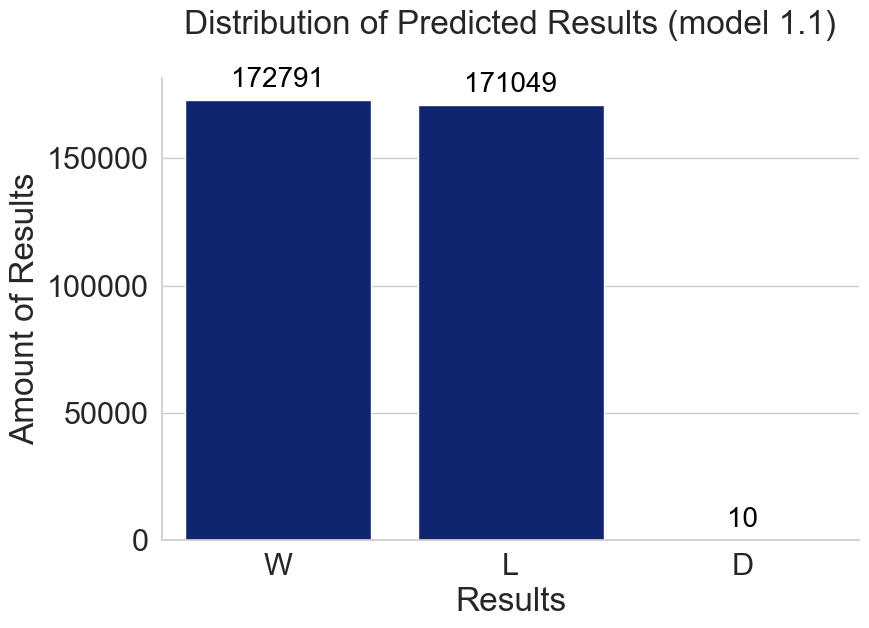

In [24]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_1.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.1)\n')
plt.xlabel('Results')
plt.ylabel('Amount of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

Model almost doesn't predict draws, as a result recall(D) = 0. Let's check it with test data.

In [54]:
test_df_1_1 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_1.predict_proba(test_df_1_1[FEATURES])
for i, class_name in enumerate(model_1_1.classes_):
    test_df_1_1[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_1['prediction'] = model_1_1.predict(test_df_1_1[FEATURES]).flatten()
test_df_1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223428 entries, 0 to 272347
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   value          223428 non-null  int64  
 1   opp_value      223428 non-null  int64  
 2   rating         223428 non-null  float64
 3   opp_rating     223428 non-null  float64
 4   race           223428 non-null  object 
 5   opp_race       223428 non-null  object 
 6   result         223428 non-null  object 
 7   random_result  223428 non-null  object 
 8   probability_D  223428 non-null  float64
 9   probability_L  223428 non-null  float64
 10  probability_W  223428 non-null  float64
 11  prediction     223428 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 30.2+ MB


In [55]:
test_df_1_1.head(6)

,value,opp_value,rating,opp_rating,race,opp_race,result,random_result,probability_D,probability_L,probability_W,prediction
0,980,985,1000.0,1000.0,woodElf,skaven,W,L,0.106856,0.498652,0.394492,L
1,985,980,1000.0,1000.0,skaven,woodElf,L,W,0.105396,0.401499,0.493105,W
2,1060,880,1588.0,1632.0,shamblingUndead,orc,W,W,0.219699,0.321405,0.458896,W
3,880,1060,1632.0,1588.0,orc,shamblingUndead,L,L,0.220646,0.441322,0.338032,L
4,980,1000,1000.0,1000.0,oldWorldAlliance,orc,L,L,0.119826,0.558089,0.322085,L
5,1000,980,1000.0,1000.0,orc,oldWorldAlliance,W,W,0.118942,0.336287,0.544771,W


In [86]:
test_accuracy_1_1 = (test_df_1_1['result'] == test_df_1_1['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_1:.1%}')

Accuracy на тестовых данных: 48.8%


## Model 1.2 - model with balanced class weights
Let's try to take class weights into account.

In [60]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [12]:
random_state = 1
X_train_1_2, X_val_1_2, y_train_1_2, y_val_1_2 = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=random_state)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_1_2), y=y_train_1_2)
class_weights_dict = dict(zip(np.unique(y_train_1_2), class_weights))

train_pool_1_2 = Pool(X_train_1_2, y_train_1_2, cat_features=CAT_FEATURES, weight=[class_weights_dict[label] for label in y_train_1_2])
eval_pool_1_2 = Pool(X_val_1_2, y_val_1_2, cat_features=CAT_FEATURES)

In [80]:
model_1_2 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_2.fit(train_pool_1_2, eval_set=eval_pool_1_2, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.3934508	test: 0.3764927	best: 0.3764927 (0)	total: 1.01s	remaining: 1h 23m 57s
100:	learn: 0.4196435	test: 0.4385691	best: 0.4385691 (100)	total: 1m 32s	remaining: 1h 14m 34s
200:	learn: 0.4219275	test: 0.4402937	best: 0.4403577 (196)	total: 3m 1s	remaining: 1h 12m 21s
300:	learn: 0.4232617	test: 0.4411197	best: 0.4413523 (273)	total: 4m 31s	remaining: 1h 10m 33s
400:	learn: 0.4243983	test: 0.4415995	best: 0.4418177 (391)	total: 5m 59s	remaining: 1h 8m 40s
500:	learn: 0.4253369	test: 0.4421899	best: 0.4422597 (487)	total: 7m 29s	remaining: 1h 7m 12s
600:	learn: 0.4260648	test: 0.4427047	best: 0.4427541 (588)	total: 8m 59s	remaining: 1h 5m 46s
700:	learn: 0.4270297	test: 0.4430391	best: 0.4430507 (699)	total: 10m 28s	remaining: 1h 4m 14s
800:	learn: 0.4278834	test: 0.4431467	best: 0.4431467 (800)	total: 11m 58s	remaining: 1h 2m 45s
900:	learn: 0.4286826	test: 0.4434463	best: 0.4435684 (894)	total: 13m 28s	remaining: 1h 1m 16s
1000:	learn: 0.4294166	test: 0.4435219	best: 0.44

In [81]:
# Save model
model_1_2.save_model('model_1_2.cbm')

In [82]:
# Load model
# model_1_2 = CatBoostClassifier()
# model_1_2.load_model('model_1_2.cbm')

In [83]:
y_pred_1_2 = model_1_2.predict(X_val_1_2)
accuracy_1_2 = accuracy_score(y_val_1_2, y_pred_1_2)
print(f'Accuracy: {accuracy_1_2:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_2, y_pred_1_2))

Accuracy: 44.4%
Classification Report:
              precision    recall  f1-score   support

           D       0.21      0.33      0.26     60035
           L       0.53      0.47      0.50    141764
           W       0.53      0.47      0.50    142051

    accuracy                           0.44    343850
   macro avg       0.42      0.42      0.42    343850
weighted avg       0.47      0.44      0.45    343850




процент побед: 36.9%
процент ничьих : 26.8%
процент поражений : 36.3%



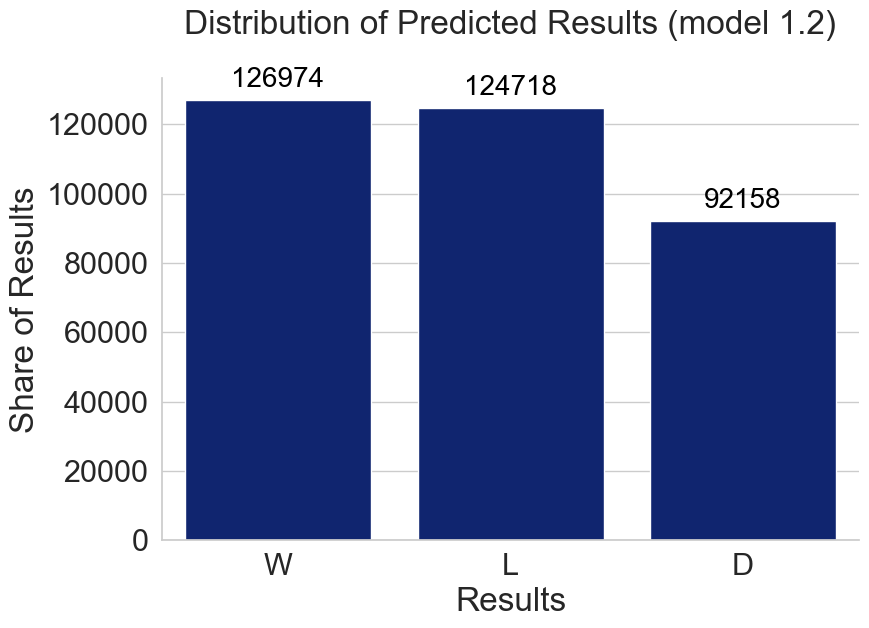

In [84]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_2.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.2)\n')
plt.xlabel('Results')
plt.ylabel('Share of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [85]:
test_df_1_2 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_2.predict_proba(test_df_1_2[FEATURES])
for i, class_name in enumerate(model_1_2.classes_):
    test_df_1_2[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_2['prediction'] = model_1_2.predict(test_df_1_2[FEATURES]).flatten()
test_df_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223428 entries, 0 to 272347
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   value          223428 non-null  int64  
 1   opp_value      223428 non-null  int64  
 2   rating         223428 non-null  float64
 3   opp_rating     223428 non-null  float64
 4   race           223428 non-null  object 
 5   opp_race       223428 non-null  object 
 6   result         223428 non-null  object 
 7   random_result  223428 non-null  object 
 8   probability_D  223428 non-null  float64
 9   probability_L  223428 non-null  float64
 10  probability_W  223428 non-null  float64
 11  prediction     223428 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 30.2+ MB


In [87]:
test_accuracy_1_2 = (test_df_1_2['result'] == test_df_1_2['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_2:.1%}')

Accuracy на тестовых данных: 42.1%


Recall is better, but accuracy is worse. Draw percent is too high. Not good: accuracy is the main metric.

## Model 1.3 - model with custom class weights
Let's try to find better class weights.

In [13]:
# Previuos model class weights
class_weights_dict

{'D': 1.9074932390264199, 'L': 0.8078923811067801, 'W': 0.8077785060363236}

In [14]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [15]:
random_state = 1
X_train_1_3, X_val_1_3, y_train_1_3, y_val_1_3 = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=random_state)

draw_weight = 1.5
class_weights = compute_class_weight(class_weight={'D': draw_weight, 'W': 1, 'L': 1} , classes=np.unique(y_train_1_3), y=y_train_1_3)
class_weights_dict = dict(zip(np.unique(y_train_1_3), class_weights))

train_pool_1_3 = Pool(X_train_1_3, y_train_1_3, cat_features=CAT_FEATURES, weight=[class_weights_dict[label] for label in y_train_1_3])
eval_pool_1_3 = Pool(X_val_1_3, y_val_1_3, cat_features=CAT_FEATURES)

In [16]:
model_1_3 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_3.fit(train_pool_1_3, eval_set=eval_pool_1_3, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.4288457	test: 0.4655431	best: 0.4655431 (0)	total: 1.18s	remaining: 1h 37m 56s
100:	learn: 0.4615348	test: 0.5017246	best: 0.5017246 (100)	total: 1m 38s	remaining: 1h 19m 46s
200:	learn: 0.4628825	test: 0.5032514	best: 0.5032514 (200)	total: 3m 16s	remaining: 1h 18m 9s
300:	learn: 0.4636671	test: 0.5037516	best: 0.5038069 (296)	total: 4m 52s	remaining: 1h 16m 7s
400:	learn: 0.4642492	test: 0.5041123	best: 0.5041152 (399)	total: 6m 25s	remaining: 1h 13m 46s
500:	learn: 0.4646323	test: 0.5042431	best: 0.5042868 (491)	total: 7m 56s	remaining: 1h 11m 21s
600:	learn: 0.4652307	test: 0.5044060	best: 0.5044554 (598)	total: 9m 31s	remaining: 1h 9m 44s
700:	learn: 0.4657312	test: 0.5043042	best: 0.5044554 (598)	total: 11m 7s	remaining: 1h 8m 16s
800:	learn: 0.4661992	test: 0.5043740	best: 0.5044554 (598)	total: 12m 41s	remaining: 1h 6m 29s
900:	learn: 0.4664837	test: 0.5044700	best: 0.5044961 (898)	total: 14m 15s	remaining: 1h 4m 52s
1000:	learn: 0.4668177	test: 0.5044991	best: 0.50

In [17]:
# Save model
model_1_3.save_model('model_1_3.cbm')

In [95]:
# Load model
# model_1_3 = CatBoostClassifier()
# model_1_3.load_model('model_1_3.cbm')

In [18]:
y_pred_1_3 = model_1_3.predict(X_val_1_3)
accuracy_1_3 = accuracy_score(y_val_1_3, y_pred_1_3)
print(f'Accuracy: {accuracy_1_3:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_3, y_pred_1_3))

Accuracy: 50.5%
Classification Report:
              precision    recall  f1-score   support

           D       0.28      0.00      0.01     60130
           L       0.50      0.61      0.55    141900
           W       0.51      0.61      0.55    141820

    accuracy                           0.50    343850
   macro avg       0.43      0.41      0.37    343850
weighted avg       0.47      0.50      0.46    343850




процент побед: 49.6%
процент ничьих : 0.2%
процент поражений : 50.2%



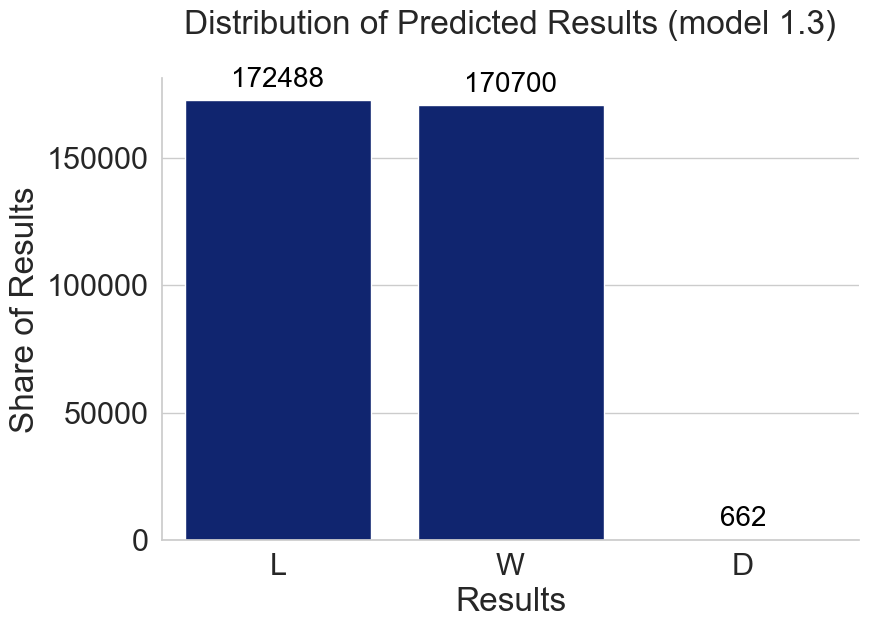

In [19]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_3.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.3)\n')
plt.xlabel('Results')
plt.ylabel('Share of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [20]:
test_df_1_3 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_3.predict_proba(test_df_1_3[FEATURES])
for i, class_name in enumerate(model_1_3.classes_):
    test_df_1_3[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_3['prediction'] = model_1_3.predict(test_df_1_3[FEATURES]).flatten()
test_accuracy_1_3 = (test_df_1_3['result'] == test_df_1_3['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_3:.1%}')

Accuracy на тестовых данных: 48.8%


Recall almost 0 again, but accuracy also raised. Let's try adjust draw_weight later.

## Model 1.4 - model with class weights and added predictors
Let's try to add 2 more predictors: value_diff (TV difference) and rating_diff (SR difference). On the one hand, they clearly follow from the existing predictors and are redundant, on the other hand, their explicit specification can simplify the task of the model.

In [99]:
df_1_4 = df.copy()
df_1_4['value_diff'] = df_1_4['value'] - df_1_4['opp_value']
df_1_4['rating_diff'] = df_1_4['rating'] - df_1_4['opp_rating']

CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'value_diff',
    'rating',
    'opp_rating',
    'rating_diff'
] + CAT_FEATURES

TARGET = 'result'

In [101]:
random_state = 1
X_train_1_4, X_val_1_4, y_train_1_4, y_val_1_4 = train_test_split(df_1_4[FEATURES], df_1_4[TARGET], test_size=0.2, random_state=random_state)

draw_weight = 1.5
class_weights = compute_class_weight(class_weight={'D': draw_weight, 'W': 1, 'L': 1} , classes=np.unique(y_train_1_4), y=y_train_1_4)
class_weights_dict = dict(zip(np.unique(y_train_1_4), class_weights))

train_pool_1_4 = Pool(X_train_1_4, y_train_1_4, cat_features=CAT_FEATURES, weight=[class_weights_dict[label] for label in y_train_1_4])
eval_pool_1_4 = Pool(X_val_1_4, y_val_1_4, cat_features=CAT_FEATURES)

In [102]:
model_1_4 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_4.fit(train_pool_1_4, eval_set=eval_pool_1_4, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.4501162	test: 0.4894867	best: 0.4894867 (0)	total: 1.01s	remaining: 1h 24m 14s
100:	learn: 0.4618260	test: 0.5014425	best: 0.5014425 (99)	total: 1m 33s	remaining: 1h 15m 27s
200:	learn: 0.4632138	test: 0.5027047	best: 0.5027076 (193)	total: 3m 12s	remaining: 1h 16m 27s
300:	learn: 0.4639375	test: 0.5030595	best: 0.5030711 (292)	total: 4m 53s	remaining: 1h 16m 26s
400:	learn: 0.4645360	test: 0.5032485	best: 0.5032747 (389)	total: 6m 32s	remaining: 1h 14m 59s
500:	learn: 0.4649174	test: 0.5033067	best: 0.5034463 (445)	total: 8m 4s	remaining: 1h 12m 26s
600:	learn: 0.4654373	test: 0.5034114	best: 0.5034550 (597)	total: 9m 34s	remaining: 1h 10m 8s
700:	learn: 0.4657739	test: 0.5033125	best: 0.5034608 (646)	total: 11m 6s	remaining: 1h 8m 10s
800:	learn: 0.4662607	test: 0.5033968	best: 0.5035044 (780)	total: 12m 39s	remaining: 1h 6m 19s
900:	learn: 0.4666144	test: 0.5035422	best: 0.5036208 (893)	total: 14m 11s	remaining: 1h 4m 34s
1000:	learn: 0.4670928	test: 0.5037633	best: 0.50

In [103]:
# Save model
model_1_4.save_model('model_1_4.cbm')

In [25]:
# Load model
# model_1_4 = CatBoostClassifier()
# model_1_4.load_model('model_1_4.cbm')

In [105]:
y_pred_1_4 = model_1_4.predict(X_val_1_4)
accuracy_1_4 = accuracy_score(y_val_1_4, y_pred_1_4)
print(f'Accuracy: {accuracy_1_4:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_4, y_pred_1_4))

Accuracy: 50.4%
Classification Report:
              precision    recall  f1-score   support

           D       0.27      0.00      0.01     60035
           L       0.50      0.61      0.55    141764
           W       0.50      0.61      0.55    142051

    accuracy                           0.50    343850
   macro avg       0.43      0.41      0.37    343850
weighted avg       0.46      0.50      0.46    343850




процент побед: 50.1%
процент ничьих : 0.3%
процент поражений : 49.6%



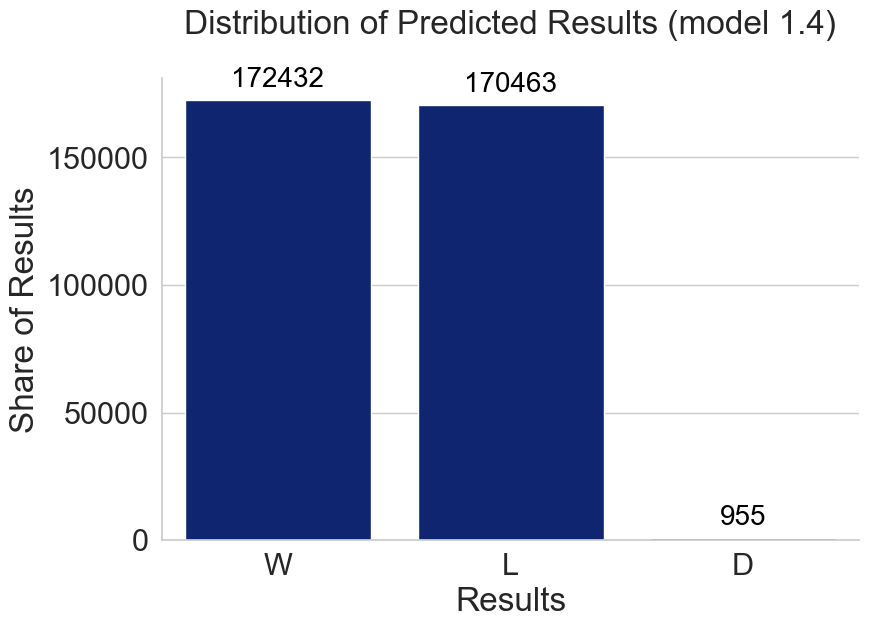

In [106]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_4.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.4)\n')
plt.xlabel('Results')
plt.ylabel('Share of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [109]:
test_df['value_diff'] = test_df['value'] - test_df['opp_value']
test_df['rating_diff'] = test_df['rating'] - test_df['opp_rating']
test_df_1_4 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_4.predict_proba(test_df_1_4[FEATURES])
for i, class_name in enumerate(model_1_4.classes_):
    test_df_1_4[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_4['prediction'] = model_1_4.predict(test_df_1_4[FEATURES]).flatten()
test_accuracy_1_4 = (test_df_1_4['result'] == test_df_1_4['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_4:.1%}')

Accuracy на тестовых данных: 48.7%


Extra predictors seemingly don't give any improvements.

# Model 1.5 - model with filtered concedes Let's see, if predictions will be better without concedes

In [26]:
df_1_5 = df[df['if_concede'] == 0][['race', 'opp_race', 'value', 'opp_value', 'rating', 'opp_rating', 'result']]
df_1_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1180514 entries, 0 to 1719245
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   race        1180514 non-null  object 
 1   opp_race    1180514 non-null  object 
 2   value       1180514 non-null  int64  
 3   opp_value   1180514 non-null  int64  
 4   rating      1180514 non-null  float64
 5   opp_rating  1180514 non-null  float64
 6   result      1180514 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 72.1+ MB


In [20]:
test_df_1_5 = test_df[test_df['if_concede'] == 0]
test_df_1_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165602 entries, 8 to 272347
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             165602 non-null  object 
 1   race           165602 non-null  object 
 2   opp_race       165602 non-null  object 
 3   value          165602 non-null  int64  
 4   opp_value      165602 non-null  int64  
 5   rating         165602 non-null  float64
 6   opp_rating     165602 non-null  float64
 7   if_concede     165602 non-null  int64  
 8   if_leaver      165602 non-null  int64  
 9   result         165602 non-null  object 
 10  random_result  165602 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 15.2+ MB



процент побед: 37.3%
процент ничьих : 25.5%
процент поражений : 37.3%



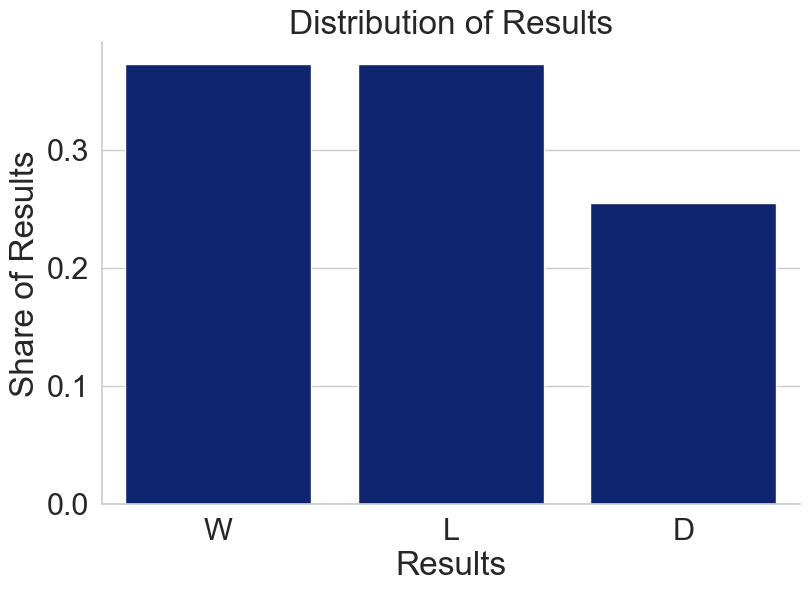

In [21]:
# Results distribution
test_class_counts = test_df_1_5['result'].value_counts(normalize=True)
W_weight = test_class_counts.W
D_weight = test_class_counts.D
L_weight = test_class_counts.L
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")
sns.barplot(x=test_class_counts.index, y=test_class_counts.values)
plt.title('Distribution of Results')
plt.xlabel('Results')
plt.ylabel('Share of Results')
sns.despine()

In [22]:
for row in test_df_1_5.itertuples():
    if row.Index % 2 == 0:
        test_df_1_5.loc[row.Index, 'random_result'] = np.random.choice(
            ['W', 'D', 'L'],
            p=[W_weight, D_weight, L_weight])
    else:
        if test_df_1_5.loc[row.Index - 1, 'random_result'] == 'W':
            test_df_1_5.loc[row.Index, 'random_result'] = 'L'
        elif test_df_1_5.loc[row.Index - 1, 'random_result'] == 'L':
            test_df_1_5.loc[row.Index, 'random_result'] = 'W'
        else:
            test_df_1_5.loc[row.Index, 'random_result'] = 'D'

test_df_1_5.head(6)

,id,race,opp_race,value,opp_value,rating,opp_rating,if_concede,if_leaver,result,random_result
8,aded0656-a670-11ef-aaf1-bc24112ec32e,blackOrc,human,1080,1205,1677.0,1446.0,0,0,W,L
9,aded0656-a670-11ef-aaf1-bc24112ec32e,human,blackOrc,1205,1080,1446.0,1677.0,0,0,L,W
14,c72e7b5a-a66f-11ef-aaf1-bc24112ec32e,darkElf,darkElf,960,1000,1600.0,1600.0,0,0,L,W
15,c72e7b5a-a66f-11ef-aaf1-bc24112ec32e,darkElf,darkElf,1000,960,1600.0,1600.0,0,0,W,L
20,986fe362-a66e-11ef-aaf1-bc24112ec32e,chaosChosen,lizardman,1590,1305,1555.0,1848.0,0,0,L,W
21,986fe362-a66e-11ef-aaf1-bc24112ec32e,lizardman,chaosChosen,1305,1590,1848.0,1555.0,0,0,W,L


In [23]:
random_accuracy = accuracy_score(test_df_1_5.result, test_df_1_5.random_result)
print(f'Accuracy with random (with actual draw share) predicting results: {random_accuracy:.1%}')

Accuracy при случайном (с учётом доли ничьих) угадывании результата: 34.1%


In [24]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [39]:
random_state = 1
X_train_1_5, X_val_1_5, y_train_1_5, y_val_1_5 = train_test_split(df_1_5[FEATURES], df_1_5[TARGET], test_size=0.2, random_state=random_state)

# draw_weight = 1.5
# class_weights = compute_class_weight(class_weight={'D': draw_weight, 'W': 1, 'L': 1}, classes=np.unique(y_train_1_5), y=y_train_1_5)
# class_weights_dict = dict(zip(np.unique(y_train_1_5), class_weights))

train_pool_1_5 = Pool(X_train_1_5, y_train_1_5, cat_features=CAT_FEATURES)
eval_pool_1_5 = Pool(X_val_1_5, y_val_1_5, cat_features=CAT_FEATURES)

In [40]:
model_1_5 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_5.fit(train_pool_1_5, eval_set=eval_pool_1_5, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.4183390	test: 0.4173433	best: 0.4173433 (0)	total: 667ms	remaining: 55m 33s
100:	learn: 0.4586202	test: 0.4581433	best: 0.4582322 (97)	total: 1m 2s	remaining: 50m 36s
200:	learn: 0.4602361	test: 0.4591217	best: 0.4593419 (194)	total: 2m 3s	remaining: 48m 58s
300:	learn: 0.4613595	test: 0.4599222	best: 0.4599857 (278)	total: 3m 2s	remaining: 47m 22s
400:	learn: 0.4623898	test: 0.4601763	best: 0.4603923 (393)	total: 4m	remaining: 45m 57s
500:	learn: 0.4631691	test: 0.4604939	best: 0.4606168 (495)	total: 4m 58s	remaining: 44m 39s
600:	learn: 0.4636096	test: 0.4608285	best: 0.4608455 (599)	total: 5m 57s	remaining: 43m 35s
700:	learn: 0.4642439	test: 0.4608031	best: 0.4609429 (694)	total: 7m	remaining: 42m 57s
800:	learn: 0.4646907	test: 0.4606761	best: 0.4609429 (694)	total: 8m 3s	remaining: 42m 12s
900:	learn: 0.4652953	test: 0.4608158	best: 0.4609429 (694)	total: 9m 6s	remaining: 41m 24s
1000:	learn: 0.4657856	test: 0.4607862	best: 0.4609429 (694)	total: 10m 5s	remaining: 40m

In [41]:
# Save model
model_1_5.save_model('model_1_5.cbm')

In [42]:
# Load model
# model_1_5 = CatBoostClassifier()
# model_1_5.load_model('model_1_5.cbm')

In [43]:
y_pred_1_5 = model_1_5.predict(X_val_1_5)
accuracy_1_5 = accuracy_score(y_val_1_5, y_pred_1_5)
print(f'Accuracy: {accuracy_1_5:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_5, y_pred_1_5))

Accuracy: 46.1%
Classification Report:
              precision    recall  f1-score   support

           D       0.40      0.00      0.00     60469
           L       0.46      0.62      0.53     87785
           W       0.46      0.62      0.53     87849

    accuracy                           0.46    236103
   macro avg       0.44      0.41      0.35    236103
weighted avg       0.45      0.46      0.39    236103




процент побед: 50.0%
процент ничьих : 0.1%
процент поражений : 49.9%



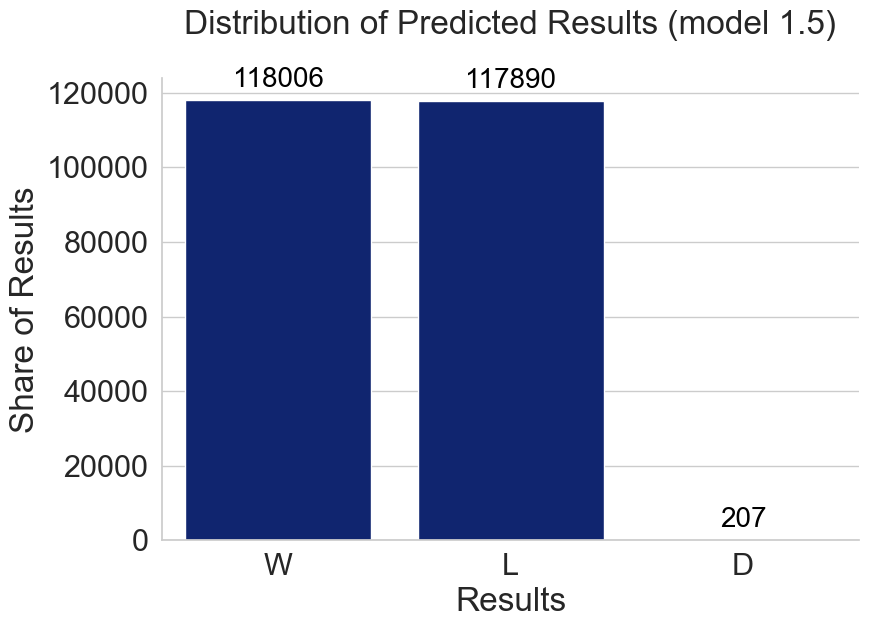

In [44]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_5.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.5)\n')
plt.xlabel('Results')
plt.ylabel('Share of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [45]:
test_df_1_5 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_5.predict_proba(test_df_1_5[FEATURES])
for i, class_name in enumerate(model_1_5.classes_):
    test_df_1_5[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_5['prediction'] = model_1_5.predict(test_df_1_5[FEATURES]).flatten()
test_accuracy_1_5 = (test_df_1_5['result'] == test_df_1_5['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_5:.1%}')

Accuracy на тестовых данных: 48.3%


No improvements comparing with model 1.1.

# Model 1.6 - model with custom class weights and smaller training dataset
Let's see, if we take only last season as training dataset

In [46]:
df_1_6 = pd.read_csv("https://drive.google.com/uc?id=1EvOyJn9yNqHJjggZQ-I6smeHsRL6fN2w")
df_1_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329224 entries, 0 to 329223
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          329224 non-null  object 
 1   race        329224 non-null  object 
 2   opp_race    329224 non-null  object 
 3   value       329224 non-null  int64  
 4   opp_value   329224 non-null  int64  
 5   rating      329224 non-null  float64
 6   opp_rating  329224 non-null  float64
 7   if_concede  329224 non-null  int64  
 8   if_leaver   329224 non-null  int64  
 9   result      329224 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 25.1+ MB


In [47]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [48]:
random_state = 1
X_train_1_6, X_val_1_6, y_train_1_6, y_val_1_6 = train_test_split(df_1_6[FEATURES], df_1_6[TARGET], test_size=0.2, random_state=random_state)

draw_weight = 1.5
class_weights = compute_class_weight(class_weight={'D': draw_weight, 'W': 1, 'L': 1} , classes=np.unique(y_train_1_6), y=y_train_1_6)
class_weights_dict = dict(zip(np.unique(y_train_1_6), class_weights))

train_pool_1_6 = Pool(X_train_1_6, y_train_1_6, cat_features=CAT_FEATURES, weight=[class_weights_dict[label] for label in y_train_1_6])
eval_pool_1_6 = Pool(X_val_1_6, y_val_1_6, cat_features=CAT_FEATURES)

In [49]:
model_1_6 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)
model_1_6.fit(train_pool_1_6, eval_set=eval_pool_1_6, plot=False, verbose=100, use_best_model=True, early_stopping_rounds=500)

0:	learn: 0.3996537	test: 0.4402916	best: 0.4402916 (0)	total: 212ms	remaining: 17m 41s
100:	learn: 0.4369587	test: 0.4781381	best: 0.4784266 (97)	total: 16.9s	remaining: 13m 38s
200:	learn: 0.4408404	test: 0.4797935	best: 0.4798998 (193)	total: 33.5s	remaining: 13m 20s
300:	learn: 0.4436019	test: 0.4795808	best: 0.4806591 (244)	total: 50.3s	remaining: 13m 4s
400:	learn: 0.4458647	test: 0.4798846	best: 0.4806591 (244)	total: 1m 6s	remaining: 12m 42s
500:	learn: 0.4476289	test: 0.4799605	best: 0.4806591 (244)	total: 1m 23s	remaining: 12m 26s
600:	learn: 0.4498658	test: 0.4793227	best: 0.4806591 (244)	total: 1m 39s	remaining: 12m 11s
700:	learn: 0.4522031	test: 0.4795656	best: 0.4806591 (244)	total: 1m 56s	remaining: 11m 55s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.4806591237
bestIteration = 244

Shrink model to first 245 iterations.


In [50]:
# Save model
model_1_6.save_model('model_1_6.cbm')

In [51]:
# Load model
# model_1_6 = CatBoostClassifier()
# model_1_6.load_model('model_1_6.cbm')

In [52]:
y_pred_1_6 = model_1_6.predict(X_val_1_6)
accuracy_1_6 = accuracy_score(y_val_1_6, y_pred_1_6)
print(f'Accuracy: {accuracy_1_6:.1%}')
print("Classification Report:")
print(classification_report(y_val_1_6, y_pred_1_6))

Accuracy: 48.1%
Classification Report:
              precision    recall  f1-score   support

           D       0.29      0.01      0.01     12730
           L       0.48      0.59      0.53     26515
           W       0.48      0.60      0.53     26600

    accuracy                           0.48     65845
   macro avg       0.42      0.40      0.36     65845
weighted avg       0.44      0.48      0.43     65845




процент побед: 50.4%
процент ничьих : 0.4%
процент поражений : 49.2%



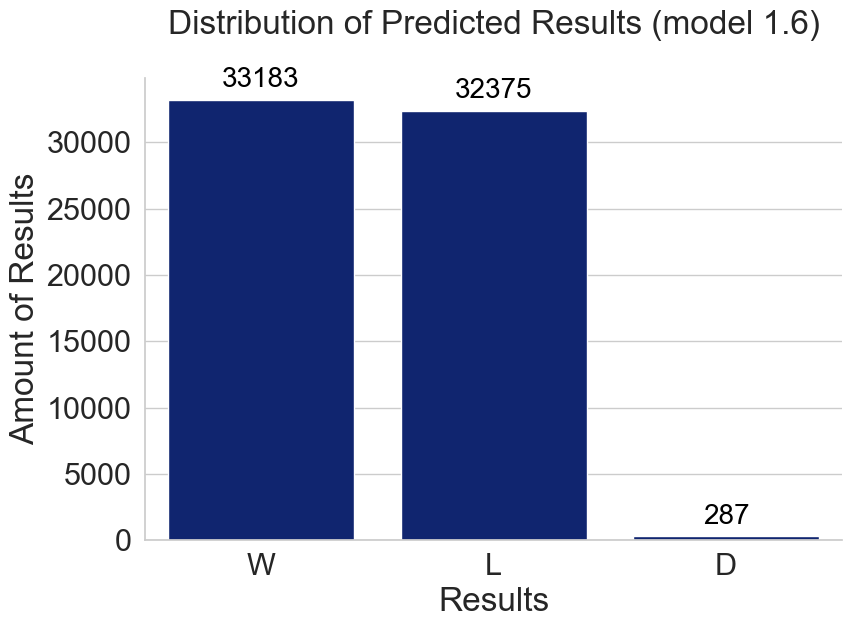

In [54]:
# Predicted results distribution
class_counts = pd.Series(y_pred_1_6.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 1.6)\n')
plt.xlabel('Results')
plt.ylabel('Amount of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [55]:
test_df_1_6 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_1_6.predict_proba(test_df_1_6[FEATURES])
for i, class_name in enumerate(model_1_6.classes_):
    test_df_1_6[f'probability_{class_name}'] = probabilities[:, i]
test_df_1_6['prediction'] = model_1_6.predict(test_df_1_6[FEATURES]).flatten()
test_accuracy_1_6 = (test_df_1_6['result'] == test_df_1_6['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_1_6:.1%}')

Accuracy на тестовых данных: 48.5%


No improvements comparing with model 1.3.

# Adjusting hyperparameters
Basing on better model (1.3), let's adjust hyperparameters.

In [6]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [7]:
random_state = 1
X_train_2_1, X_val_2_1, y_train_2_1, y_val_2_1 = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=random_state)

In [27]:
# Function for adjusting hyperparameters
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 20)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 1)
    draw_weight = trial.suggest_float('draw_weight', 1.0, 2.0)

    class_weights = compute_class_weight(
        class_weight={'D': draw_weight, 'W': 1, 'L': 1}, 
        classes=np.unique(y_train_2_1), 
        y=y_train_2_1
    )
    class_weights_dict = dict(zip(np.unique(y_train_2_1), class_weights))

    train_pool_2_1 = Pool(X_train_2_1, y_train_2_1, cat_features=CAT_FEATURES, 
                      weight=[class_weights_dict[label] for label in y_train_2_1])
    eval_pool_2_1 = Pool(X_val_2_1, y_val_2_1, cat_features=CAT_FEATURES)
  
    model_2_1 = CatBoostClassifier(
        iterations=5000,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        cat_features=CAT_FEATURES,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        random_seed=random_state,
        verbose=0
    )

    model_2_1.fit(train_pool_2_1, eval_set=eval_pool_2_1, verbose=False, use_best_model=True, early_stopping_rounds=500)

    y_pred_2_1 = model_2_1.predict(X_val_2_1)
    accuracy_2_1 = accuracy_score(y_val_2_1, y_pred_2_1)
    print(f"Trial {trial.number}, accuracy: {accuracy_2_1:.1%}")

    return accuracy_2_1

# Saving results function
def save_results(study, filename='optuna_results.csv'):
    results = study.trials_dataframe()
    results.to_csv(filename, index=False)
    print(f"Результаты сохранены в '{filename}'")

# Loading results function
def load_results(filename='optuna_results.csv'):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    return None

In [9]:
# Loading existing results
results_df = load_results()
if results_df is not None:
    print("Загруженные результаты:")
    print(results_df)
    start_trial = len(results_df)  # Starting iteration
else:
    start_trial = 0  # If no existing results, start with 0

# New study
study = optuna.create_study(direction='maximize', study_name="BB_predictions")

# Hyperparametres optimisation
try:
    for i in range(start_trial, 200):  # Start from last iteration
        study.optimize(objective, n_trials=1, n_jobs=6, show_progress_bar=True)
        last_trial = study.trials[-1]
        accuracy = last_trial.value
        save_results(study)  # Save results after each iteration
except KeyboardInterrupt:
    print("Optimization interrupted. results saved.")

# Best results and accuracy
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2024-11-28 14:50:03,454] A new study created in memory with name: BB_predictions


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 0, accuracy: 50.5%
[I 2024-11-28 15:54:51,741] Trial 0 finished with value: 0.5047607968590956 and parameters: {'learning_rate': 0.015247327185954698, 'depth': 5, 'l2_leaf_reg': 16, 'bagging_temperature': 0.33845146713288, 'draw_weight': 1.0614138521076892}. Best is trial 0 with value: 0.5047607968590956.
Результаты сохранены в 'optuna_results.csv'
0 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 1, accuracy: 49.9%
[I 2024-11-28 16:27:38,254] Trial 1 finished with value: 0.4993718191071688 and parameters: {'learning_rate': 0.03978581595784864, 'depth': 6, 'l2_leaf_reg': 10, 'bagging_temperature': 0.8962678885008277, 'draw_weight': 1.7820515056009625}. Best is trial 0 with value: 0.5047607968590956.
Результаты сохранены в 'optuna_results.csv'
1 trial, accuracy = 49.9%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 2, accuracy: 50.5%
[I 2024-11-28 16:59:04,505] Trial 2 finished with value: 0.505179584120983 and parameters: {'learning_rate': 0.09636188342069889, 'depth': 5, 'l2_leaf_reg': 7, 'bagging_temperature': 0.6957012259360544, 'draw_weight': 1.038782292231987}. Best is trial 2 with value: 0.505179584120983.
Результаты сохранены в 'optuna_results.csv'
2 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 3, accuracy: 50.4%
[I 2024-11-28 17:51:04,985] Trial 3 finished with value: 0.5039784789879308 and parameters: {'learning_rate': 0.012665453192413701, 'depth': 4, 'l2_leaf_reg': 14, 'bagging_temperature': 0.9252790755686408, 'draw_weight': 1.2269885351037915}. Best is trial 2 with value: 0.505179584120983.
Результаты сохранены в 'optuna_results.csv'
3 trial, accuracy = 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 4, accuracy: 50.4%
[I 2024-11-28 18:04:53,164] Trial 4 finished with value: 0.5043769085356987 and parameters: {'learning_rate': 0.1787787542312296, 'depth': 5, 'l2_leaf_reg': 8, 'bagging_temperature': 0.29928423821224737, 'draw_weight': 1.5123191995002374}. Best is trial 2 with value: 0.505179584120983.
Результаты сохранены в 'optuna_results.csv'
4 trial, accuracy = 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 5, accuracy: 49.3%
[I 2024-11-28 19:01:04,001] Trial 5 finished with value: 0.49294750618002037 and parameters: {'learning_rate': 0.01328980560084124, 'depth': 8, 'l2_leaf_reg': 12, 'bagging_temperature': 0.4428133368463626, 'draw_weight': 1.8982616145760827}. Best is trial 2 with value: 0.505179584120983.
Результаты сохранены в 'optuna_results.csv'
5 trial, accuracy = 49.3%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 6, accuracy: 50.5%
[I 2024-11-28 20:25:42,103] Trial 6 finished with value: 0.5053773447724298 and parameters: {'learning_rate': 0.02590343226569945, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.05063173203977955, 'draw_weight': 1.2404745542589755}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
6 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 7, accuracy: 50.3%
[I 2024-11-28 20:37:42,953] Trial 7 finished with value: 0.5031496291987786 and parameters: {'learning_rate': 0.3256886555775962, 'depth': 6, 'l2_leaf_reg': 19, 'bagging_temperature': 0.028256208734956823, 'draw_weight': 1.6518404328082257}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
7 trial, accuracy = 50.3%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 8, accuracy: 50.5%
[I 2024-11-28 21:14:31,702] Trial 8 finished with value: 0.5052348407735932 and parameters: {'learning_rate': 0.11852419103157817, 'depth': 6, 'l2_leaf_reg': 11, 'bagging_temperature': 0.5206417423752475, 'draw_weight': 1.3261693272869448}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
8 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 9, accuracy: 50.5%
[I 2024-11-28 21:28:51,825] Trial 9 finished with value: 0.504993456449033 and parameters: {'learning_rate': 0.13423714033006293, 'depth': 4, 'l2_leaf_reg': 4, 'bagging_temperature': 0.4845186557291472, 'draw_weight': 1.3498676151869116}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
9 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 10, accuracy: 50.4%
[I 2024-11-28 22:55:30,538] Trial 10 finished with value: 0.5044001744946924 and parameters: {'learning_rate': 0.04056389197705904, 'depth': 10, 'l2_leaf_reg': 1, 'bagging_temperature': 0.0660826388731447, 'draw_weight': 1.5151278954619296}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
10 trial, accuracy = 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 11, accuracy: 50.5%
[I 2024-11-29 00:22:37,457] Trial 11 finished with value: 0.5051708593863603 and parameters: {'learning_rate': 0.04365121305367752, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.7051151304750518, 'draw_weight': 1.2689120015524493}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
11 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 12, accuracy: 50.5%
[I 2024-11-29 01:08:57,266] Trial 12 finished with value: 0.5046561000436237 and parameters: {'learning_rate': 0.025228053603064318, 'depth': 8, 'l2_leaf_reg': 14, 'bagging_temperature': 0.17541652583050893, 'draw_weight': 1.3796441630831346}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
12 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 13, accuracy: 50.4%
[I 2024-11-29 01:48:39,471] Trial 13 finished with value: 0.5037719936018613 and parameters: {'learning_rate': 0.4768136133169488, 'depth': 10, 'l2_leaf_reg': 6, 'bagging_temperature': 0.6255053319070786, 'draw_weight': 1.1721365826921568}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
13 trial, accuracy = 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 14, accuracy: 50.5%
[I 2024-11-29 02:35:34,480] Trial 14 finished with value: 0.505365711792933 and parameters: {'learning_rate': 0.06781785708064128, 'depth': 7, 'l2_leaf_reg': 12, 'bagging_temperature': 0.23369922228759268, 'draw_weight': 1.4071480811360924}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
14 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 15, accuracy: 50.3%
[I 2024-11-29 03:17:25,500] Trial 15 finished with value: 0.5030740148320488 and parameters: {'learning_rate': 0.06318690983406851, 'depth': 9, 'l2_leaf_reg': 20, 'bagging_temperature': 0.16310305066636843, 'draw_weight': 1.6653163883548245}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
15 trial, accuracy = 50.3%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 16, accuracy: 50.5%
[I 2024-11-29 04:32:49,329] Trial 16 finished with value: 0.5051068779991276 and parameters: {'learning_rate': 0.022516513572336225, 'depth': 7, 'l2_leaf_reg': 17, 'bagging_temperature': 0.21560711043621228, 'draw_weight': 1.4060178141712136}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
16 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 17, accuracy: 50.5%
[I 2024-11-29 04:56:51,873] Trial 17 finished with value: 0.5052813726915806 and parameters: {'learning_rate': 0.06526647917724067, 'depth': 7, 'l2_leaf_reg': 13, 'bagging_temperature': 0.01148839834455151, 'draw_weight': 1.1685881374785343}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
17 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 18, accuracy: 50.4%
[I 2024-11-29 06:09:51,586] Trial 18 finished with value: 0.5038185255198487 and parameters: {'learning_rate': 0.023879078149813597, 'depth': 9, 'l2_leaf_reg': 9, 'bagging_temperature': 0.31809913203962853, 'draw_weight': 1.6184958132966494}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
18 trial, accuracy = 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 19, accuracy: 50.5%
[I 2024-11-29 06:37:40,516] Trial 19 finished with value: 0.5046880907372401 and parameters: {'learning_rate': 0.17561883880244095, 'depth': 9, 'l2_leaf_reg': 5, 'bagging_temperature': 0.14362263801407482, 'draw_weight': 1.4248110671000633}. Best is trial 6 with value: 0.5053773447724298.
Результаты сохранены в 'optuna_results.csv'
19 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 20, accuracy: 50.6%
[I 2024-11-29 08:01:29,322] Trial 20 finished with value: 0.5055082157917696 and parameters: {'learning_rate': 0.031964755228899265, 'depth': 7, 'l2_leaf_reg': 3, 'bagging_temperature': 0.27270064118712467, 'draw_weight': 1.1294358446317139}. Best is trial 20 with value: 0.5055082157917696.
Результаты сохранены в 'optuna_results.csv'
20 trial, accuracy = 50.6%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 21, accuracy: 50.5%
[I 2024-11-29 08:51:39,989] Trial 21 finished with value: 0.5053744365275556 and parameters: {'learning_rate': 0.031567526759644346, 'depth': 7, 'l2_leaf_reg': 2, 'bagging_temperature': 0.2604846179105473, 'draw_weight': 1.1195344130604212}. Best is trial 20 with value: 0.5055082157917696.
Результаты сохранены в 'optuna_results.csv'
21 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 22, accuracy: 50.6%
[I 2024-11-29 10:16:17,910] Trial 22 finished with value: 0.5056827104842228 and parameters: {'learning_rate': 0.030708578714718104, 'depth': 8, 'l2_leaf_reg': 1, 'bagging_temperature': 0.10197588421707271, 'draw_weight': 1.004161718918664}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
22 trial, accuracy = 50.6%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 23, accuracy: 50.5%
[I 2024-11-29 11:06:00,571] Trial 23 finished with value: 0.5049992729387814 and parameters: {'learning_rate': 0.017613393046375395, 'depth': 8, 'l2_leaf_reg': 3, 'bagging_temperature': 0.10620362086230639, 'draw_weight': 1.0099431060174662}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
23 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 24, accuracy: 50.5%
[I 2024-11-29 12:19:44,764] Trial 24 finished with value: 0.5052842809364548 and parameters: {'learning_rate': 0.030881224114464728, 'depth': 8, 'l2_leaf_reg': 1, 'bagging_temperature': 0.37752657679989754, 'draw_weight': 1.1188325680896283}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
24 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 25, accuracy: 50.5%
[I 2024-11-29 14:20:26,422] Trial 25 finished with value: 0.5048916678784353 and parameters: {'learning_rate': 0.010162721355084711, 'depth': 9, 'l2_leaf_reg': 4, 'bagging_temperature': 0.11425380638631415, 'draw_weight': 1.2677570393412059}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
25 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 26, accuracy: 50.6%
[I 2024-11-29 15:26:37,726] Trial 26 finished with value: 0.5055402064853861 and parameters: {'learning_rate': 0.05164575674407901, 'depth': 6, 'l2_leaf_reg': 3, 'bagging_temperature': 0.3978368959443349, 'draw_weight': 1.0973973052882315}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
26 trial, accuracy = 50.6%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 27, accuracy: 50.5%
[I 2024-11-29 16:36:17,614] Trial 27 finished with value: 0.5054180602006689 and parameters: {'learning_rate': 0.04855536205648559, 'depth': 6, 'l2_leaf_reg': 3, 'bagging_temperature': 0.4040698431569452, 'draw_weight': 1.098352997663777}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
27 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 28, accuracy: 48.6%
[I 2024-11-29 16:54:18,781] Trial 28 finished with value: 0.48604042460375163 and parameters: {'learning_rate': 0.05329334018952059, 'depth': 6, 'l2_leaf_reg': 6, 'bagging_temperature': 0.4928320170450608, 'draw_weight': 1.9951901572885895}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
28 trial, accuracy = 48.6%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 29, accuracy: 50.5%
[I 2024-11-29 17:59:42,678] Trial 29 finished with value: 0.5049992729387814 and parameters: {'learning_rate': 0.017767582737974682, 'depth': 5, 'l2_leaf_reg': 1, 'bagging_temperature': 0.5749934772040075, 'draw_weight': 1.0272271075549257}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
29 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 30, accuracy: 50.5%
[I 2024-11-29 18:18:47,730] Trial 30 finished with value: 0.5049265668169259 and parameters: {'learning_rate': 0.08837505517913082, 'depth': 7, 'l2_leaf_reg': 3, 'bagging_temperature': 0.339704883870593, 'draw_weight': 1.1747024491546791}. Best is trial 22 with value: 0.5056827104842228.
Результаты сохранены в 'optuna_results.csv'
30 trial, accuracy = 50.5%


  0%|          | 0/1 [00:00<?, ?it/s]

Trial 31, accuracy: 50.6%
[I 2024-11-29 19:07:22,872] Trial 31 finished with value: 0.5055314817507635 and parameters: {'learning_rate': 0.050492656769637545, 'depth': 6, 'l2_leaf_reg': 3, 'bagging_temperature': 0.42676371041883554, 'draw_weight': 1.0829796754491614}. Best is trial 22 with value: 0.5056827104842228.
Оптимизация прервана. Результаты сохранены.
Best hyperparameters:  {'learning_rate': 0.030708578714718104, 'depth': 8, 'l2_leaf_reg': 1, 'bagging_temperature': 0.10197588421707271, 'draw_weight': 1.004161718918664}
Best accuracy:  0.5056827104842228


# Saving best model

In [21]:
# Load data from CSV
dfs = pd.read_csv('optuna_results.csv')

# Make new study
study_name = "BB_predictions"  # Our study name

# Create or load study
study = optuna.create_study(study_name=study_name, direction='maximize', load_if_exists=True)

# Add results to study
for index, row in dfs.iterrows():
    # Extract data
    trial_number = row['number']
    value = row['value']
    params = {
        'learning_rate': row['params_learning_rate'],
        'depth': row['params_depth'],
        'l2_leaf_reg': row['params_l2_leaf_reg'],
        'bagging_temperature': row['params_bagging_temperature'],
        'draw_weight': row['params_draw_weight']
    }
    state = row['state']

    # Change date to datetime
    datetime_start = pd.to_datetime(row['datetime_start'])
    datetime_complete = pd.to_datetime(row['datetime_complete'])

    # Make distributions
    distributions = {
        'learning_rate': optuna.distributions.FloatDistribution(low=0.01, high=0.5, log=True),
        'depth': optuna.distributions.IntDistribution(low=4, high=10),
        'l2_leaf_reg': optuna.distributions.IntDistribution(low=1, high=20),
        'bagging_temperature': optuna.distributions.FloatDistribution(low=0.0, high=1.0),
        'draw_weight': optuna.distributions.FloatDistribution(low=1.0, high=2.0)
    }

    # Make new trial and add results
    study.add_trial(optuna.trial.FrozenTrial(
        number=trial_number,
        value=value,
        params=params,
        state=optuna.trial.TrialState.COMPLETE if state == 'COMPLETE' else optuna.trial.TrialState.FAIL,
        datetime_start=datetime_start,
        datetime_complete=datetime_complete,
        distributions=distributions,
        user_attrs={},
        system_attrs={},
        intermediate_values={},
        trial_id=trial_number  # Use trial_number as trial_id
    ))

# Now our study is restored from previously saved DataFrame
print(f"Study '{study_name}' restored with {len(study.trials)} trial(s).")

[I 2024-12-04 18:37:06,651] A new study created in memory with name: BB_predictions


Study 'BB_predictions' восстановлен с 31 trial(s).


In [21]:
results_df = load_results()
results_df

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_depth,params_draw_weight,params_l2_leaf_reg,params_learning_rate,state
0,0,0.504761,2024-11-28 14:50:03.472085,2024-11-28 15:54:51.741261,0 days 01:04:48.269176,0.338451,5,1.061414,16,0.015247,COMPLETE
1,1,0.499372,2024-11-28 15:54:51.756911,2024-11-28 16:27:38.254965,0 days 00:32:46.498054,0.896268,6,1.782052,10,0.039786,COMPLETE
2,2,0.505180,2024-11-28 16:27:38.270582,2024-11-28 16:59:04.505462,0 days 00:31:26.234880,0.695701,5,1.038782,7,0.096362,COMPLETE
3,3,0.503978,2024-11-28 16:59:04.521088,2024-11-28 17:51:04.985043,0 days 00:52:00.463955,0.925279,4,1.226989,14,0.012665,COMPLETE
4,4,0.504377,2024-11-28 17:51:05.000659,2024-11-28 18:04:53.164202,0 days 00:13:48.163543,0.299284,5,1.512319,8,0.178779,COMPLETE
5,5,0.492948,2024-11-28 18:04:53.182508,2024-11-28 19:01:04.001893,0 days 00:56:10.819385,0.442813,8,1.898262,12,0.013290,COMPLETE
6,6,0.505377,2024-11-28 19:01:04.023574,2024-11-28 20:25:42.103996,0 days 01:24:38.080422,0.050632,8,1.240475,10,0.025903,COMPLETE
7,7,0.503150,2024-11-28 20:25:42.128504,2024-11-28 20:37:42.953638,0 days 00:12:00.825134,0.028256,6,1.651840,19,0.325689,COMPLETE
8,8,0.505235,2024-11-28 20:37:42.970932,2024-11-28 21:14:31.702307,0 days 00:36:48.731375,0.520642,6,1.326169,11,0.118524,COMPLETE
9,9,0.504993,2024-11-28 21:14:31.717900,2024-11-28 21:28:51.825848,0 days 00:14:20.107948,0.484519,4,1.349868,4,0.134237,COMPLETE


In [22]:
study.best_value

0.5056827104842228

In [23]:
study.best_params

{'learning_rate': 0.0307085787147181,
 'depth': 8,
 'l2_leaf_reg': 1,
 'bagging_temperature': 0.1019758842170727,
 'draw_weight': 1.004161718918664}

In [24]:
CAT_FEATURES = [
    'race',
    'opp_race'
]

FEATURES = [
    'value',
    'opp_value',
    'rating',
    'opp_rating'
] + CAT_FEATURES

TARGET = 'result'

In [25]:
random_state = 1
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=random_state)

In [26]:
draw_weight = study.best_params['draw_weight']
class_weights = compute_class_weight(class_weight={'D': draw_weight, 'W': 1, 'L': 1} , classes=np.unique(y_train_3), y=y_train_3)
class_weights_dict = dict(zip(np.unique(y_train_3), class_weights))

train_pool_3 = Pool(X_train_3, y_train_3, cat_features=CAT_FEATURES, weight=[class_weights_dict[label] for label in y_train_3])
eval_pool_3 = Pool(X_val_3, y_val_3, cat_features=CAT_FEATURES)

In [26]:
model_3 = CatBoostClassifier(
    iterations=5000,
    learning_rate=study.best_params['learning_rate'],
    depth=study.best_params['depth'],
    l2_leaf_reg=study.best_params['l2_leaf_reg'],
    bagging_temperature=study.best_params['bagging_temperature'],
    cat_features=CAT_FEATURES,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=random_state,
    verbose=100
)

In [28]:
model_3.fit(train_pool_3, eval_set=eval_pool_3, plot=False, verbose=100, use_best_model=True)

0:	learn: 0.4692427	test: 0.4704144	best: 0.4704144 (0)	total: 1.38s	remaining: 1h 55m 16s
100:	learn: 0.4989615	test: 0.5000698	best: 0.5000698 (100)	total: 2m 28s	remaining: 1h 59m 42s
200:	learn: 0.5013250	test: 0.5020881	best: 0.5020881 (200)	total: 4m 57s	remaining: 1h 58m 21s
300:	learn: 0.5024227	test: 0.5032252	best: 0.5032369 (297)	total: 7m 26s	remaining: 1h 56m 17s
400:	learn: 0.5032154	test: 0.5038011	best: 0.5038418 (395)	total: 9m 54s	remaining: 1h 53m 35s
500:	learn: 0.5039180	test: 0.5040570	best: 0.5040861 (499)	total: 12m 22s	remaining: 1h 51m 8s
600:	learn: 0.5045167	test: 0.5041588	best: 0.5041588 (600)	total: 14m 52s	remaining: 1h 48m 49s
700:	learn: 0.5051880	test: 0.5043362	best: 0.5043449 (698)	total: 17m 20s	remaining: 1h 46m 23s
800:	learn: 0.5055673	test: 0.5045369	best: 0.5045776 (768)	total: 19m 54s	remaining: 1h 44m 19s
900:	learn: 0.5059510	test: 0.5046997	best: 0.5048568 (861)	total: 22m 36s	remaining: 1h 42m 51s
1000:	learn: 0.5063114	test: 0.5048451	be

In [29]:
# Save model
model_3.save_model('model_3.cbm')

In [28]:
# Load model
# model_3 = CatBoostClassifier()
# model_3.load_model('model_3.cbm')

In [15]:
y_pred_3 = model_3.predict(X_val_3)
accuracy_3 = accuracy_score(y_val_3, y_pred_3)
print(f'Accuracy: {accuracy_3:.1%}')
print("Classification Report:")
print(classification_report(y_val_3, y_pred_3))

Accuracy: 50.9%
Classification Report:
              precision    recall  f1-score   support

           D       0.93      0.00      0.00     60189
           L       0.51      0.62      0.56    141842
           W       0.51      0.62      0.56    141819

    accuracy                           0.51    343850
   macro avg       0.65      0.41      0.37    343850
weighted avg       0.58      0.51      0.46    343850




процент побед: 50.0%
процент ничьих : 0.0%
процент поражений : 50.0%



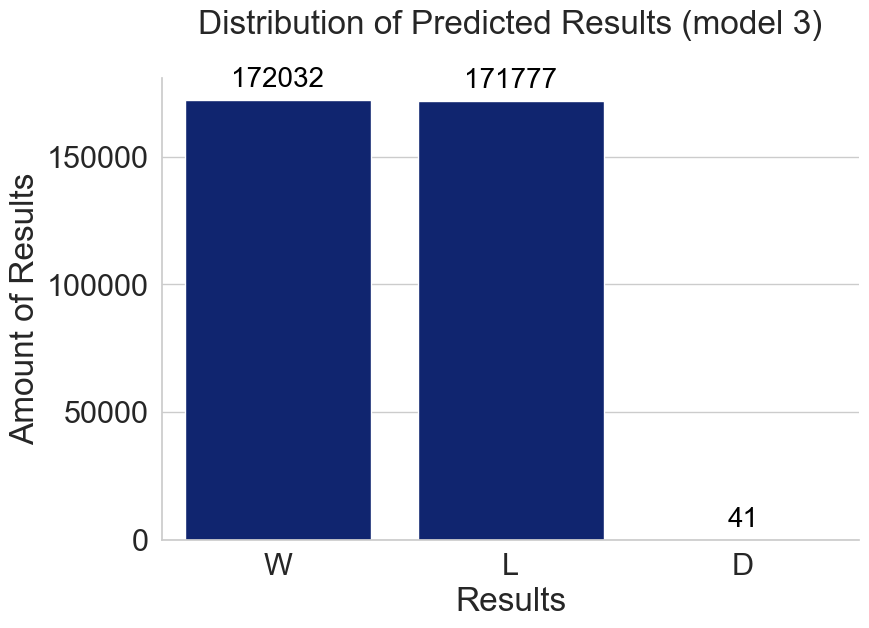

In [16]:
# Predicted results distribution
class_counts = pd.Series(y_pred_3.flatten()).value_counts(normalize=False)
sum_counts = class_counts.sum()
W_weight = class_counts.W / sum_counts
D_weight = class_counts.D / sum_counts
L_weight = class_counts.L / sum_counts
print(f"""
percent of wins: {W_weight:.1%}
percent of draws: {D_weight:.1%}
percent of losses: {L_weight:.1%}
""")

ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Predicted Results (model 3)\n')
plt.xlabel('Results')
plt.ylabel('Amount of Results')

for p in ax.patches:
    count = int(p.get_height())  
    ax.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=20, color='black', 
                      xytext=(0, 5),
                      textcoords='offset points')
    
sns.despine()

In [17]:
test_df_3 = test_df[FEATURES + ['result', 'random_result']].copy()
probabilities = model_3.predict_proba(test_df_3[FEATURES])
for i, class_name in enumerate(model_3.classes_):
    test_df_3[f'probability_{class_name}'] = probabilities[:, i]
test_df_3['prediction'] = model_3.predict(test_df_3[FEATURES]).flatten()
test_accuracy_3 = (test_df_3['result'] == test_df_3['prediction']).mean()

print(f'Test data accuracy: {test_accuracy_3:.1%}')

Accuracy на тестовых данных: 48.9%


Well, that's our best accuracy. Better than random/

Model is bad at predicting draws, but since our target metric is accuracy, we'll not improve recall at cost of acuracy.

# Feature importance
Let's visualize it.

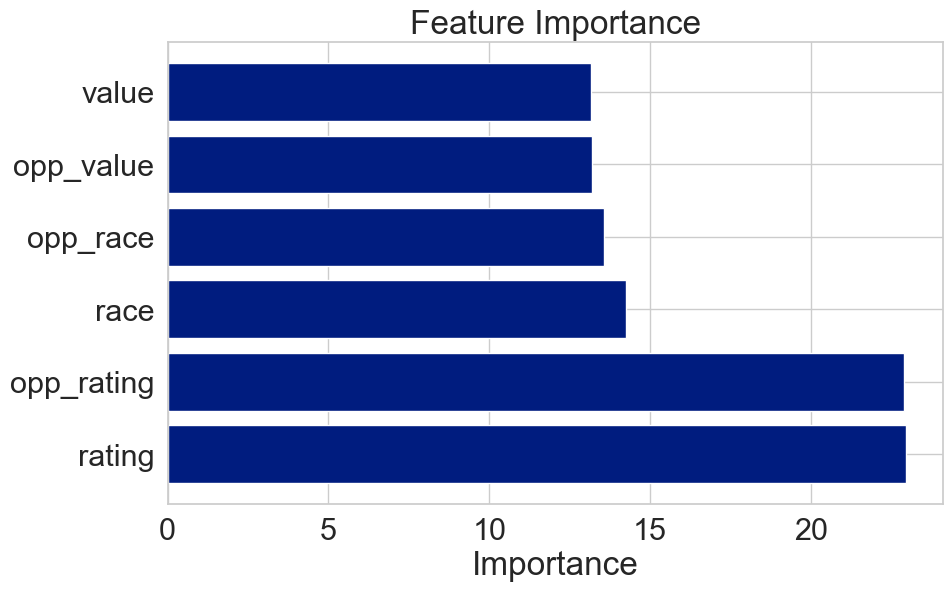

In [29]:
# Feature importance
feature_importances = model_3.get_feature_importance()
feature_names = FEATURES

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Results
Goal are mainly reached: 
 - created model, which predicts match results;
 - higher accuracy, than random predictions;
 - goblins-bookmakers are panicking.
   
However, some weak sides:
- accuracy is low (about 50%). Probably, Blood Bowl is too random. Or we need better predictors (but these are the easiest and available from in-gave at match start).
- model is bad at predicting draws. Recall (D) is almost 0. But this can not be improved without lowering accuracy.
- predictions are not always symmetric, i.g., results from opponent's POV not always will be opposite. If we insert similar data for tea, and for opponent, win and loss chances will be different (I can't understand why).